# Run abricate for each database and create summaries

#### Author: Liubov Chuprikova

In [1]:
# import modules
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.getdefaultencoding()

'utf-8'

In [2]:
# functions and variables
ABRICATE_PATH = '/home/liubov/repos/abricate/bin/abricate'
GENOMES_PATH = '/home/liubov/PycharmProjects/ExplorePipolin/data/new_analysis/pipolin_sequences'
# GENOMES_PATH = '/home/liubov/Documents/tfm/the_whole_analysis/abricate_pipolins/long_sequences'
WORKING_DIR = '/home/liubov/PycharmProjects/ExplorePipolin/data/new_analysis/abricate'
# WORKING_DIR = '/home/liubov/Documents/tfm/the_whole_analysis/abricate_pipolins/abricate_long'

def get_abricate_databases():
    """
    Run `abricate --list` and parse available databases from stdout.
    """
    abricate_list = subprocess.run([ABRICATE_PATH, '--list'],
                                   stdout=subprocess.PIPE, 
                                   stderr=subprocess.STDOUT).stdout.decode('utf-8')
    databases = []
    for line in abricate_list.split('\n'):
        entry = line.split('\t')[0]
        if entry != 'DATABASE' and entry != '':
            databases.append(entry)
    return databases

def run_abricate(database_dir, genomes_dir):
    """
    Screen all the genomes in the genomes_dir against the given database.
    """
    snp_databases = ['fumC', 'fimH', 'pointFinder_Ecoli']
    # %id=95 (https://cge.cbs.dtu.dk/services/CHTyper/)
    # %id=85 %cov=60 (https://cge.cbs.dtu.dk/services/SerotypeFinder/)
    db = os.path.basename(database_dir)
    if db in snp_databases: 
        minid, mincov = '95', '95'
    elif db == 'ecoh':
        minid, mincov = '85', '60'
    else:   # default
        minid, mincov = '75', '0'
    in_genomes = os.listdir(genomes_dir)
    os.mkdir(database_dir)
    for genome in in_genomes:
        print(f'\nRunning for the genome {genome}...')
        with open(os.path.join(database_dir, f'{genome[:-3]}.tab', ), 'w') as ouf:
            subprocess.run([ABRICATE_PATH, '--db', db, 
                            '--minid', minid, '--mincov', mincov,
                            '--threads', '4', '--nopath', 
                            f'{os.path.join(genomes_dir, genome)}'], stdout=ouf)

def abricate_summarize(databases, out_dir):
    summaries_dir = os.path.join(out_dir, 'summaries')
    
    if not os.path.exists(summaries_dir):
        os.mkdir(summaries_dir)
    
    for db in databases:
        db_out_path = os.path.join(out_dir, db)
        if not os.path.isdir(db_out_path):
            continue
        if os.path.isfile(os.path.join(summaries_dir, f'{db}.tab')):
            continue
        db_out_files = ' '.join([os.path.join(db_out_path, file) for file in os.listdir(db_out_path)])
        with open(os.path.join(summaries_dir, f'{db}.tab'), 'w') as ouf:
            subprocess.run(f'{ABRICATE_PATH} --nopath --summary {db_out_files}',
                           shell=True, stdout=ouf)

def parse_summaries(databases, summaries_dir):
    summaries_data = pd.DataFrame(columns=databases, 
                                      index=[f'{file[:-3]}.tab' for file in os.listdir(GENOMES_PATH)])
    for db in databases:
        summary_file = os.path.join(summaries_dir, f'{db}.tab')
        if not os.path.isfile(summary_file):
            continue
        with open(summary_file) as inf:
            for line in inf:
                if line[0] != '#':
                    genome, number = line.strip().split(sep='\t')[:2]
                    summaries_data.at[genome, db] = number

    return summaries_data

def set_chtype(from_df, to_df, chtype):
    for _, row in from_df.iterrows():
        entry = row['#FILE']
        index_array = np.flatnonzero(row.iloc[2:].notna()) + 2
        if len(index_array) > 1:
            raise AssertionError('More than a single variation locus was defined!')
        if len(index_array) == 0:
            entry_type = np.nan
        else:
            entry_type = row.index[index_array[0]]
        to_df.at[entry, chtype] = entry_type

def set_ohtype(from_df, to_df):
    for _, row in from_df.iterrows():
        entry = row['#FILE']
        index_array = np.flatnonzero(row.iloc[2:].notna()) + 2
        entry_types = [row.index[index] for index in index_array]
        to_df.at[entry, 'ecoh'] = ';'.join([etype for etype in entry_types])

def plot_counts_by_type(types_ndarray):
    types, counts = np.unique(types_ndarray, return_counts=True)
    counts_sorted = np.sort(counts)[::-1]
    types_sorted = types[(-counts).argsort()]
    plt.bar(x=types_sorted, height=counts_sorted)
    plt.ylim(top=np.max(counts))
    plt.xticks(rotation=90)
    
    return plt.show()

def count_lines_in_file(file_path):
    with open(file_path) as inf:
        for i, l in enumerate(inf):
            pass
    return i + 1
    
def clean_dirs():
    wdir_content = os.listdir(WORKING_DIR)
    for content in wdir_content:
        content_path = os.path.join(WORKING_DIR, content)
        if os.path.isdir(content_path):
            files = os.listdir(content_path)
            for file in files:
                if count_lines_in_file(os.path.join(content_path, file)) == 1:   # only header line
                    os.remove(os.path.join(content_path, file))

### 1. Run abricate with all available databases and summarize the output

In [3]:
abricate_dbs = get_abricate_databases()
[i for i in abricate_dbs]

['ecoli_virfinder',
 'ecoh',
 'vfdb',
 'megares_noSNPs',
 'integron',
 'argannot',
 'fumC',
 'ncbi',
 'card',
 'resfinder',
 'fimH',
 'ecoli_vf',
 'plasmidfinder']

In [5]:
# DBs_to_skip = ['ecoh', 'integron', 'fumC', 'fimH', 'plasmidfinder']   # COMMENT IT
DBs_to_skip = []

for database in abricate_dbs:
    if database in DBs_to_skip:
        continue
    db_dir = os.path.join(WORKING_DIR, database)
    if not os.path.isdir(db_dir):
        print(f'\n>>>Running for the database {os.path.basename(db_dir)}')
        run_abricate(db_dir, GENOMES_PATH)


>>>Running for the database ecoli_virfinder

Running for the genome NCTC9080.fa...

Running for the genome 112648.fa...

Running for the genome LREC258.fa...

Running for the genome GCA_009002655.1.fa...

Running for the genome L41-1.fa...

Running for the genome ATCC_43886.fa...

Running for the genome LREC256.fa...

Running for the genome 99-3165.fa...

Running for the genome 2011EL-1370-2.fa...

Running for the genome LREC260.fa...

Running for the genome LREC244.fa...

Running for the genome L73.fa...

Running for the genome GCF_000941935.1.fa...

Running for the genome M6.fa...

Running for the genome 2014EL-1343-2.fa...

Running for the genome RM13516.fa...

Running for the genome LREC255.fa...

Running for the genome NCTC9967.fa...

Running for the genome RM14721.fa...

Running for the genome M15.fa...

Running for the genome CVM_N62675.fa...

Running for the genome M19.fa...

Running for the genome F5656C1.fa...

Running for the genome LREC245.fa...

Running for the genome 109


Running for the genome 10942.fa...

Running for the genome CVM_N17EC1164.fa...

Running for the genome D181.fa...

Running for the genome LREC240.fa...

Running for the genome LREC241.fa...

Running for the genome LREC237.fa...

Running for the genome LREC249.fa...

Running for the genome LREC239.fa...

Running for the genome LREC261.fa...

Running for the genome 214-4.fa...

Running for the genome NCYU-21-79.fa...

Running for the genome CRE1540.fa...

Running for the genome LREC246.fa...

Running for the genome 08-00022.fa...

Running for the genome 2452.fa...

Running for the genome NCTC5934.fa...

Running for the genome M9682.fa...

Running for the genome L37.fa...

Running for the genome LREC262.fa...

Running for the genome UFU_EC98.fa...

Running for the genome H10407.fa...

Running for the genome CVM_N56639.fa...

Running for the genome RM9872.fa...

Running for the genome FHI87.fa...

Running for the genome YY76-1.fa...

Running for the genome F5505-C1.fa...

Running for the 


Running for the genome 2014EL-1346-6.fa...

Running for the genome 210205630_210221272.fa...

Running for the genome M9.fa...

Running for the genome 3-373-03_S1_C2.fa...

Running for the genome LREC242.fa...

Running for the genome LREC250.fa...

Running for the genome FWSEC0002.fa...

Running for the genome FMU073332.fa...

Running for the genome LREC243.fa...

Running for the genome NCYU-29-19.fa...

Running for the genome E706.fa...

Running for the genome 13C1065T.fa...

Running for the genome LREC251.fa...

Running for the genome H1.fa...

Running for the genome FHI82.fa...

Running for the genome 122715.fa...

Running for the genome LREC254.fa...

Running for the genome LREC259.fa...

Running for the genome P12b.fa...

Running for the genome LREC253.fa...

Running for the genome LREC248.fa...

Running for the genome WCHEC050613.fa...

Running for the genome 203740.fa...

Running for the genome CFSAN061762.fa...

Running for the genome L100.fa...

Running for the genome ECCHD184


Running for the genome ECCHD184.fa...

Running for the genome CV839-06.fa...

Running for the genome L53.fa...

Running for the genome M11.fa...

Running for the genome AR_0085.fa...

Running for the genome MEM.fa...

Running for the genome S30.fa...

Running for the genome RM12761.fa...

Running for the genome LREC257.fa...

Running for the genome SLK172.fa...

Running for the genome S43.fa...

Running for the genome 2015C-3125.fa...

Running for the genome LREC247.fa...

Running for the genome L103-2.fa...

Running for the genome 13P484A.fa...

Running for the genome CP53.fa...

Running for the genome 789.fa...

Running for the genome HKUOPY1.fa...

Running for the genome LREC252.fa...

>>>Running for the database ncbi

Running for the genome NCTC9080.fa...

Running for the genome 112648.fa...

Running for the genome LREC258.fa...

Running for the genome GCA_009002655.1.fa...

Running for the genome L41-1.fa...

Running for the genome ATCC_43886.fa...

Running for the genome LREC256


Running for the genome LREC256.fa...

Running for the genome 99-3165.fa...

Running for the genome 2011EL-1370-2.fa...

Running for the genome LREC260.fa...

Running for the genome LREC244.fa...

Running for the genome L73.fa...

Running for the genome GCF_000941935.1.fa...

Running for the genome M6.fa...

Running for the genome 2014EL-1343-2.fa...

Running for the genome RM13516.fa...

Running for the genome LREC255.fa...

Running for the genome NCTC9967.fa...

Running for the genome RM14721.fa...

Running for the genome M15.fa...

Running for the genome CVM_N62675.fa...

Running for the genome M19.fa...

Running for the genome F5656C1.fa...

Running for the genome LREC245.fa...

Running for the genome 10942.fa...

Running for the genome CVM_N17EC1164.fa...

Running for the genome D181.fa...

Running for the genome LREC240.fa...

Running for the genome LREC241.fa...

Running for the genome LREC237.fa...

Running for the genome LREC249.fa...

Running for the genome LREC239.fa...

Run


Running for the genome LREC261.fa...

Running for the genome 214-4.fa...

Running for the genome NCYU-21-79.fa...

Running for the genome CRE1540.fa...

Running for the genome LREC246.fa...

Running for the genome 08-00022.fa...

Running for the genome 2452.fa...

Running for the genome NCTC5934.fa...

Running for the genome M9682.fa...

Running for the genome L37.fa...

Running for the genome LREC262.fa...

Running for the genome UFU_EC98.fa...

Running for the genome H10407.fa...

Running for the genome CVM_N56639.fa...

Running for the genome RM9872.fa...

Running for the genome FHI87.fa...

Running for the genome YY76-1.fa...

Running for the genome F5505-C1.fa...

Running for the genome 2014EL-1346-6.fa...

Running for the genome 210205630_210221272.fa...

Running for the genome M9.fa...

Running for the genome 3-373-03_S1_C2.fa...

Running for the genome LREC242.fa...

Running for the genome LREC250.fa...

Running for the genome FWSEC0002.fa...

Running for the genome FMU073332.

In [6]:
abricate_summarize(abricate_dbs, WORKING_DIR)

In [7]:
# clean_dirs()   # COMMENT IT

In [7]:
summaries = parse_summaries(abricate_dbs, os.path.join(WORKING_DIR, 'summaries'))

### 2. Define *fimH* and *fumC* types

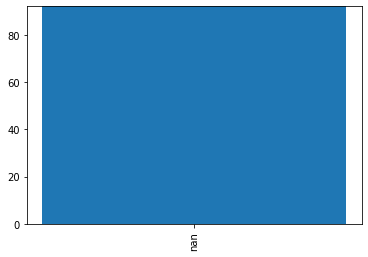

In [8]:
fimh_summary = pd.read_csv(os.path.join(WORKING_DIR, 'summaries', 'fimH.tab'), 
                               sep='\t', na_values='.')

set_chtype(fimh_summary, summaries, 'fimH')

plot_counts_by_type(summaries['fimH'].to_numpy(dtype=str))

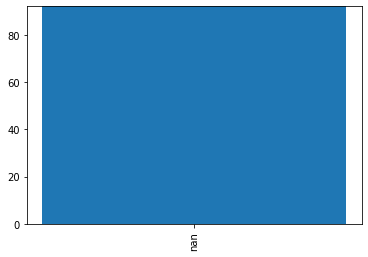

In [9]:
fumc_summary = pd.read_csv(os.path.join(WORKING_DIR, 'summaries', 'fumC.tab'),
                               sep='\t', na_values='.')

set_chtype(fumc_summary, summaries, 'fumC')

plot_counts_by_type(summaries['fumC'].to_numpy(dtype=str))

### 3. Define *OH* serotypes

In [10]:
ecoh_summary = pd.read_csv(os.path.join(WORKING_DIR, 'summaries', 'ecoh.tab'),
                              sep='\t', na_values='.')

set_ohtype(ecoh_summary, summaries)

# It'll be easier to edit OH-types manually!

In [11]:
# uncomment to rewrite the file
summaries.to_csv(os.path.join(WORKING_DIR, 'short_summary.csv'))